# Process the ATL06-SR data prior to DEM sampling 
________________________

Some of this code was originally adapted by Hannah Besso from code written by David Shean in 2021
______________

### Steps In This Notebook:    
* Reproject ATL06-SR data to local UTM coordinate reference system
* Label ATL06SR data as snow-on (snow_presence = 1) or snow-off (snow_presence = 0) based on snow presence at SNOTEL sites.   

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from astropy.time import Time
import datetime
import pickle

In [5]:
%matplotlib inline

In [7]:
pd.set_option('display.max_columns', None)

In [9]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

# Load SlideRule

In [3]:
atl06sr = pickle.load(open('../../data/atl06/methow_all_sr-atl06-10182022.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_30488/1215892880.py:1: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  atl06sr = pickle.load(open('../../data/atl06/methow_all_sr-atl06-10182022.pkl', 'rb'))


In [11]:
atl06sr.head(2)

,pflags,h_mean,dh_fit_dy,spot,w_surface_window_final,h_sigma,distance,segment_id,dh_fit_dx,rgt,cycle,delta_time,gt,n_fit_photons,rms_misfit,geometry,acqdate
time,,,,,,,,,,,,,,,,,
2018-11-09 22:09:43.662511060,0,774.110259,0.0,5,9.386548,0.079705,5.382001e+06,268398,0.367318,646,1,2.703658e+07,20,41,0.506044,POINT (-120.00053 48.33917),2018-11-09
2018-11-09 22:09:43.789049908,0,919.941824,0.0,5,3.000000,0.050617,5.382903e+06,268443,0.028568,646,1,2.703658e+07,20,42,0.305572,POINT (-120.00167 48.34723),2018-11-09


In [12]:
atl06sr.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
atl06sr_gdf = atl06sr.to_crs('epsg:32610')

In [14]:
add_dowy(atl06sr_gdf)

Adding Day of Water Year (DOWY)


In [15]:
atl06sr_gdf.head(2)

,pflags,h_mean,dh_fit_dy,spot,w_surface_window_final,h_sigma,distance,segment_id,dh_fit_dx,rgt,cycle,delta_time,gt,n_fit_photons,rms_misfit,geometry,acqdate,doy,decyear,dowy
time,,,,,,,,,,,,,,,,,,,,
2018-11-09 22:09:43.662511060,0,774.110259,0.0,5,9.386548,0.079705,5.382001e+06,268398,0.367318,646,1,2.703658e+07,20,41,0.506044,POINT (722265.057 5358346.501),2018-11-09,313,2018.857324,40
2018-11-09 22:09:43.789049908,0,919.941824,0.0,5,3.000000,0.050617,5.382903e+06,268443,0.028568,646,1,2.703658e+07,20,42,0.305572,POINT (722145.580 5359238.959),2018-11-09,313,2018.857324,40


## Export a snow-off point file for use with pc_align

In [18]:
# Did this to create a csv file to use with pc_align
#atl06sr_gdf_ll['x'] = atl06sr_gdf_ll.geometry.x.values
#atl06sr_gdf_ll['y'] = atl06sr_gdf_ll.geometry.y.values
#add_dowy(atl06sr_gdf_ll)
#atl06sr_gdf_ll.to_csv(r'ATL06-SR_Methow_20220201183616_004.csv', index=None)

## Load a polygon of the study area

In [16]:
outline_gdf = pickle.load(open('../../data/site_outlines/methow_outline_32610.pkl', 'rb'))

### Find the Area of the Study Site

In [17]:
area = outline_gdf['geometry'].area/ 10**6
area

3    1792.769054
dtype: float64

In [18]:
# This is UTM Zone 11N
outline_snowoff_extent = outline_gdf.total_bounds
outline_snowoff_extent

array([ 678410.08018125, 5347236.59329467,  731239.08413885,
       5409664.78384497])

### Plot the study site and ATL06-SR data:

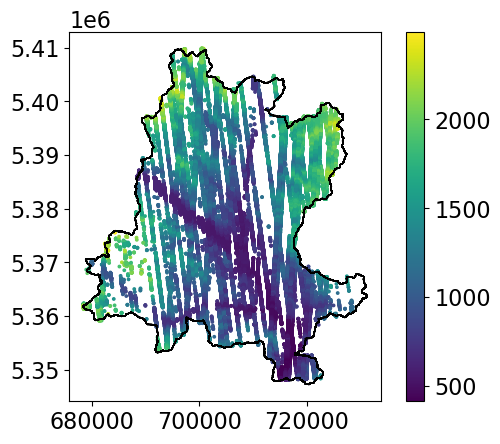

In [19]:
fig, ax = plt.subplots()

atl06sr_gdf.plot(column='h_mean', ax=ax, markersize=3, legend=True)
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k');

### Load snow data, cleaned in AUX_data_clean.ipynb:

In [29]:
snwd = pickle.load(open('../data/snotel/snotel_snwd_35.pkl', 'rb'))

In [30]:
snwd.head(2)

,SNOTEL:1259_WA_SNTL,SNOTEL:728_WA_SNTL,doy,decyear,dowy
datetime,,,,,
2018-10-03 00:00:00+00:00,0.0,0.0,276,2018.753425,3
2018-10-04 00:00:00+00:00,0.0,0.0,277,2018.756164,4


### Plot the snow depth:

Text(0, 0.5, 'Snow Depth m')

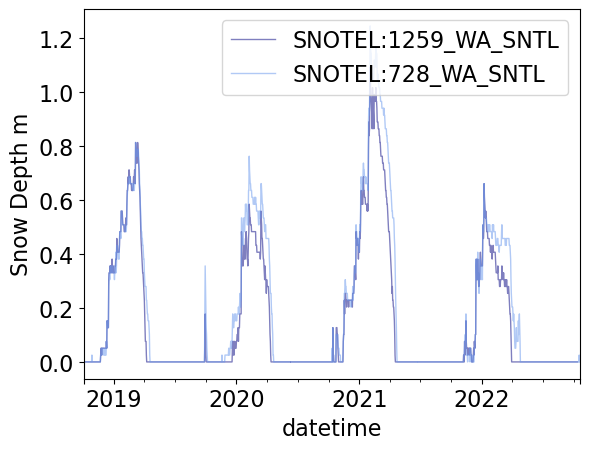

In [31]:
fig, ax = plt.subplots()
snwd[['SNOTEL:1259_WA_SNTL','SNOTEL:728_WA_SNTL']].plot(alpha=0.5, color=['navy', 'cornflowerblue'], lw=1, ax=ax)
#ax.axhline(y = 0, c = 'k')
plt.ylabel('Snow Depth m')

### Determine average snow-free dates:

In [32]:
idx_st = (snwd[['SNOTEL:1259_WA_SNTL', 'SNOTEL:728_WA_SNTL']] < 0.1).all(axis=1)

(90.0, 360.0)

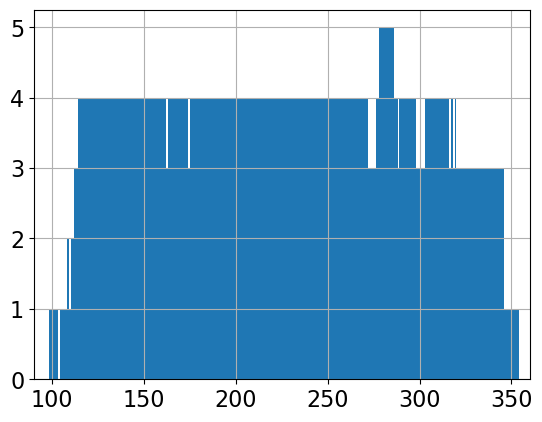

In [41]:
fig, ax = plt.subplots()
snwd[idx_st]['doy'].hist(bins=365, range=(0,365), ax=ax)
ax.set_xlim(90, 360)

I'm suspicious of this - too many snow free days, the snotel sites are pretty low compared to the study site

In [42]:
snowfree_doy_range = (100,350)

In [43]:
snowoff_days_percent = (snowfree_doy_range[1] - snowfree_doy_range[0]) / 360 * 100
snowoff_days_percent

69.44444444444444

### Label data as snow off or snow on:

In [44]:
idx = (atl06sr_gdf['doy'] >= snowfree_doy_range[0]) & (atl06sr_gdf['doy'] <= snowfree_doy_range[1])

In [46]:
atl06sr_gdf['snow_presence'] = ""
atl06sr_gdf.loc[idx, 'snow_presence'] = 0
atl06sr_gdf.loc[~idx, 'snow_presence'] = 1

In [47]:
atl06sr_gdf.head(2)

,pflags,h_mean,dh_fit_dy,spot,w_surface_window_final,h_sigma,distance,segment_id,dh_fit_dx,rgt,cycle,delta_time,gt,n_fit_photons,rms_misfit,geometry,acqdate,doy,decyear,dowy,snow_presence
time,,,,,,,,,,,,,,,,,,,,,
2018-11-09 22:09:43.662511060,0,774.110259,0.0,5,9.386548,0.079705,5.382001e+06,268398,0.367318,646,1,2.703658e+07,20,41,0.506044,POINT (722265.057 5358346.501),2018-11-09,313,2018.857324,40,0
2018-11-09 22:09:43.789049908,0,919.941824,0.0,5,3.000000,0.050617,5.382903e+06,268443,0.028568,646,1,2.703658e+07,20,42,0.305572,POINT (722145.580 5359238.959),2018-11-09,313,2018.857324,40,0


### Plot the occurence of snow-on and snow-off data:

Text(0.5, 1.0, 'Snow On')

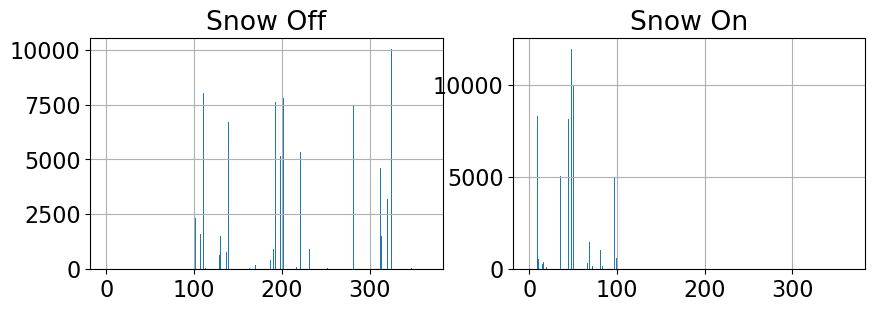

In [48]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
atl06sr_gdf['doy'][atl06sr_gdf['snow_presence'] == 0].hist(bins=365, range=(0,365), ax=ax[0])
atl06sr_gdf['doy'][atl06sr_gdf['snow_presence'] == 1].hist(bins=365, range=(0,365), ax=ax[1])
ax[0].set_title('Snow Off')
ax[1].set_title('Snow On')

### Save as a new file:

In [50]:
# Save progress: save ATL06SR file prior to DEM differencing (done on Oct 18, 2022 to save my progress in this notebook temporarily)

atl06sr_temp_fn = '../../data/atl06/methow_all_sr-atl06-10172022_processed_wo-dems.pkl'

with open(atl06sr_temp_fn, 'wb') as f:
    pickle.dump(atl06sr_gdf, f)